<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# ARIMA Lab

_Author: Unknown_

-----

One of the most common applications for ARIMA models is inventory planning. In this lab, you will be analyzing weekly Walmart sales data over a two year period from 2010 to 2012.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

# often necessary b/c pandas & statsmodels datetime issue
import warnings
warnings.simplefilter(action="ignore")

In [2]:
# Remove scientific notation
pd.set_option('display.float_format', lambda x: '%.5f' % x)

### Importing and exploring the data

After importing, check the following:
- Is there any missing data?
- What are the column datatypes?
- How many observations are there?
- How many unique stores are there?
- How many unique departments are there?

In [3]:
walmart = pd.read_csv('datasets/train.csv')
walmart.head(3)

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50000,False
1,1,1,2010-02-12,46039.49000,True
2,1,1,2010-02-19,41595.55000,False


In [4]:
walmart.isnull().sum()

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
dtype: int64

In [5]:
walmart.dtypes

Store             int64
Dept              int64
Date             object
Weekly_Sales    float64
IsHoliday          bool
dtype: object

In [6]:
walmart["Date"] = pd.to_datetime(walmart["Date"])

In [7]:
walmart.dtypes

Store                    int64
Dept                     int64
Date            datetime64[ns]
Weekly_Sales           float64
IsHoliday                 bool
dtype: object

In [8]:
len(walmart["Store"].unique()) # 45 unique store

45

In [9]:
len(walmart["Dept"].unique()) # 81 unique department

81

**Creating a datetime index**

Convert the `Date` column to datetime, and set it as the index for the dataframe.

In [10]:
walmart.set_index("Date",drop=True,inplace=True)

In [11]:
walmart # Weekly Sales Dataframe

,Store,Dept,Weekly_Sales,IsHoliday
Date,,,,
2010-02-05,1,1,24924.50000,False
2010-02-12,1,1,46039.49000,True
2010-02-19,1,1,41595.55000,False
2010-02-26,1,1,19403.54000,False
2010-03-05,1,1,21827.90000,False
...,...,...,...,...
2012-09-28,45,98,508.37000,False
2012-10-05,45,98,628.10000,False
2012-10-12,45,98,1061.02000,False


**Getting weekly sales for store 1**

To simplify our work somewhat, we'll consider **only** sales from store 1, and we'll aggregate sales from all departments in store 1.

Create a new dataframe that contains weekly sales for store 1.

> **Note**: You might break this up into multiple steps, or you might do this in one line.
>
> To aggregate, use **groupby**. We're tallying up all sales that have the same date, _not_ aggregating many dates based on year or month.
>
> The only column you'll need to keep is `Weekly_Sales`. You should get rid of the `Store`, `Dept`, and `IsHoliday` columns in your new dataframe.

In [12]:
store1 = walmart[walmart["Store"] == 1]["Weekly_Sales"]

In [13]:
store1.describe()

count    10244.00000
mean     21710.54362
std      27748.94551
min       -863.00000
25%       3465.62250
50%      10289.37500
75%      31452.95750
max     203670.47000
Name: Weekly_Sales, dtype: float64

In [14]:
store1sum = store1.groupby('Date').sum()

In [15]:
# Remove scientific notation
# pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [16]:
store1sum.describe()

count       143.00000
mean    1555264.39755
std      155980.76776
min     1316899.31000
25%     1458104.69000
50%     1534849.64000
75%     1614892.03000
max     2387950.20000
Name: Weekly_Sales, dtype: float64

---

### Plotting and interpreting a time series

**Generate a line plot**

Generate a line plot for weekly sales, with time on the $x$-axis and sales on the $y$-axis. Make sure the plot has a title, and make sure axes are labeled where appropriate.

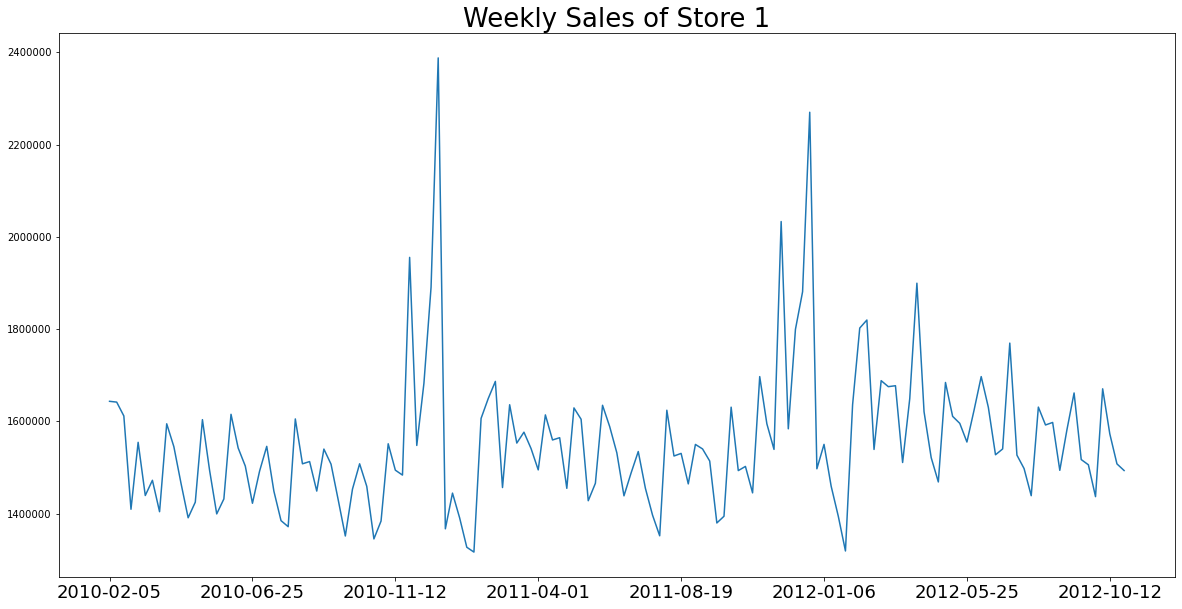

In [24]:
# Plot our weekly sales
pd.set_option('display.float_format', lambda x: '%.5f' % x)
plt.figure(figsize=(20,10))
plt.plot(store1sum)
plt.title("Weekly Sales of Store 1", fontsize=26)
plt.xticks(store1sum.index[0::20], fontsize=18);
plt.ticklabel_format(style='plain', axis='y', scilimits=(0,0)); # Remove scientific notation on y-axis

**Plotting rolling means**

Smoothing can help us see trends in the data. On one graph, plot the following:

- Weekly sales
- The 4-week rolling mean of weekly sales
- The 13-week rolling mean of weekly sales
    - (This is included because there are 13 weeks in a business quarter!)

Make sure the plot has a title, axis labels where appropriate, and a legend.

> **(BONUS)**: Add vertical lines on the plot to indicate January 2011 and January 2012.

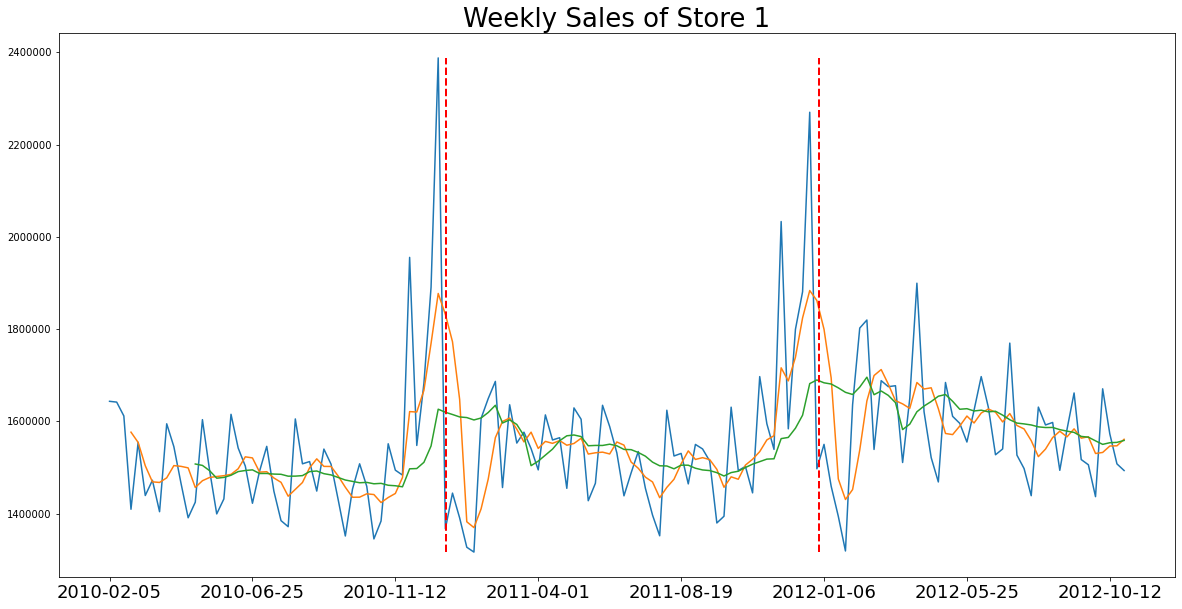

In [33]:
# Plot our weekly sales
pd.set_option('display.float_format', lambda x: '%.5f' % x)
plt.figure(figsize=(20,10))
plt.plot(store1sum)
plt.title("Weekly Sales of Store 1", fontsize=26)
plt.xticks(store1sum.index[0::20], fontsize=18);
plt.ticklabel_format(style='plain', axis='y', scilimits=(0,0)) # Remove scientific notation on y-axis

plt.plot(store1sum.rolling(4).mean()); # Monthly average
plt.plot(store1sum.rolling(13).mean()); # Quarterly average
plt.vlines(x=pd.to_datetime('2011-01-01'), ymin = store1sum.min(), ymax=store1sum.max(), 
           color='r', linestyle='--', lw=2);
plt.vlines(x=pd.to_datetime('2012-01-01'), ymin = store1sum.min(), ymax=store1sum.max(), 
           color='r', linestyle='--', lw=2);

**Describe any trends that you notice**

In [19]:
# A: There is a clear seasonality where the sale increase considerably at last quarter near the end of the year.
# There is a dip in sale after new year for a few weeks and then return to the normal level.

---

### Autocorrelation and partial autocorrelation

Recall that autocorrelation and partial autocorrelation tell us about how a variable is related to itself at previous lags.

**Plot and interpret the autocorrelation**

Use statsmodels to plot the ACF and PACF. Look at up to **52 lags**. 

What do you notice? Provide a written answer along with your ACF/PACF plots below.

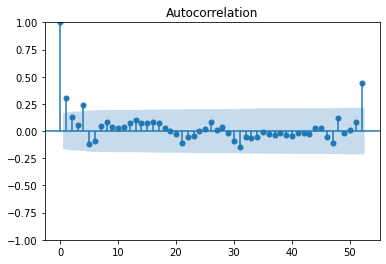

In [36]:
plot_acf(store1sum, lags = 52);

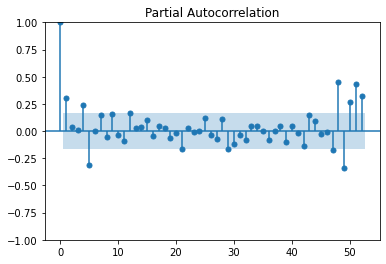

In [38]:
plot_pacf(store1sum, lags= 52);

In [20]:
# A: It is confirmed that there is a yearly seasonality element along with two and five weeks seasonal on sales.

---

### Modeling

**Train-test splitting**

Before fitting a model, we should train-test split. Use the first 90% of observations as training data, and use the remaining 10% as testing data. Remember -- we **do not need to shuffle the data**!

In [40]:
y_train, y_test = train_test_split(store1sum, 
                                   test_size= 0.10,
                                   shuffle=False)

In [42]:
y_train.tail()

Date
2012-06-15   1630607.00000
2012-06-22   1527845.81000
2012-06-29   1540421.49000
2012-07-06   1769854.16000
2012-07-13   1527014.04000
Name: Weekly_Sales, dtype: float64

In [43]:
y_test.head()

Date
2012-07-20   1497954.76000
2012-07-27   1439123.71000
2012-08-03   1631135.79000
2012-08-10   1592409.97000
2012-08-17   1597868.05000
Name: Weekly_Sales, dtype: float64

**Evaluating stationarity**

Use the augmented Dickey-Fuller test to evaluate the weekly sales data, and interpret the result.

In [45]:
def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index= ["Test Statistic",
                                          "p-value"])
    return dfoutput

In [46]:
interpret_dftest(adfuller(store1sum))

Test Statistic   -5.10219
p-value           0.00001
dtype: float64

In [ ]:
# The adfuller test suggest that we have stationary data.
# Hence, we might not need to differentiate. We should still check in case it provide better result.

---

**Fit and evaluate an AR(1) model**

We'll start with a simple autoregressive model with order 1. In statsmodels, an autoregressive model with order $p=1$ can be implemented by instantiating and fitting an ARIMA model with order $(1,0,0)$.

Instantiate and fit your model on the training data.

In [48]:
arima = ARIMA(endog=store1sum, order = (1,0,0))
model = arima.fit()

### Evaluating the model

**Store predictions**

Remember that statsmodels ARIMA models generate predictions off of `start` and `end` dates.

Generate and store predictions for the training and testing data.

In [55]:
preds = model.predict(start="2012-07-20", end="2012-10-26")
#preds

In [56]:
#y_test

**Mean squared error**

Use the `mean_squared_error` function to identify the MSE on the testing data.

In [53]:
mean_squared_error(y_test, preds) # MSE

5863325131.700673

In [54]:
mean_squared_error(y_test, preds, squared=False) # RMSE

76572.35226699433

**Generate a plot of the training data, testing data, train preds, and test preds**

Create a plot showing the training data, testing data, train preds, and test preds. Make sure there are labels and legends.

> **Note**: You'll be making more similar plots. You might consider writing a function to generate your plots!

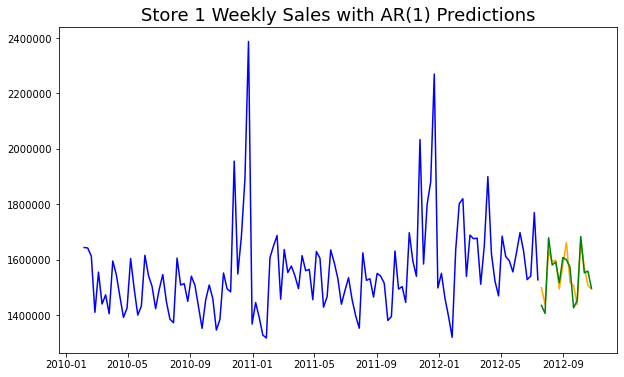

In [81]:
# Plot data
plt.figure(figsize=(10,6))
plt.plot(y_train, color = 'blue')
plt.plot(y_test, color = 'orange')
plt.plot(preds, color = 'green')
plt.title(label = 'Store 1 Weekly Sales with AR(1) Predictions', fontsize=18)
plt.ticklabel_format(style='plain', axis='y', scilimits=(0,0)); # Remove scientific notation on y-axis
plt.show();

**Interpretation**

How well or how poorly does the model seem to perform? Provide a brief interpretation.

The model seem to perform poorly as it does not reflect the seasonal variations and the level of variation is significantly lower then actual values.

---

**Fit and evaluate an ARMA(2,2) model**

In statsmodels, an autoregressive moving average model with order $p=2$, $q=2$ can be implemented by instantiating and fitting an ARIMA model with order $(2,0,2)$.

Instantiate and fit your model on the training data:

In [59]:
arima2 = ARIMA(endog=store1sum, order = (2,0,2))
model2 = arima2.fit()

### Evaluating the model

**Store predictions**

Generate and store predictions for train and test.

In [63]:
preds2 = model2.predict(start="2012-07-20", end="2012-10-26")
#preds

**Mean squared error**

Find the MSE of the testing data.

In [64]:
mean_squared_error(y_test, preds2) # MSE

4725985452.019201

In [65]:
mean_squared_error(y_test, preds2, squared=False) # RMSE

68745.8031593144

**Generate a plot of the training data, testing data, train preds, and test preds**

As before, plot your data and predictions.

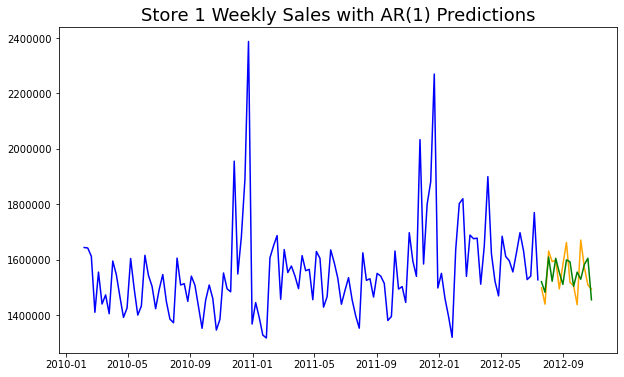

In [82]:
# Plot data
plt.figure(figsize=(10,6))
plt.plot(y_train, color = 'blue')
plt.plot(y_test, color = 'orange')
plt.plot(preds2, color = 'green')
plt.title(label = 'Store 1 Weekly Sales with AR(1) Predictions', fontsize=18)
plt.ticklabel_format(style='plain', axis='y', scilimits=(0,0)); # Remove scientific notation on y-axis
plt.show();

**Intepretation**

How well or how poorly does the model seem to perform? Provide a brief interpretation.

In [21]:
# A: The model seem to perform better than AR(1) but as we did not have differentiation or seasonality. 
# It is highly likely that we could optimise the model.

---

**Fit and evaluate an ARIMA(2,1,2) model**

Instantiate and fit an ARIMA model with order $(2,1,2)$.

In [67]:
arima3 = ARIMA(endog=store1sum, order = (2,1,2))
model3 = arima3.fit()

### Evaluating the model

**Store predictions**

Generate and store predictions for train and test.

In [68]:
preds3 = model3.predict(start="2012-07-20", end="2012-10-26")
#preds

**Mean squared error**

Find the MSE on your testing data.

In [69]:
mean_squared_error(y_test, preds3) # MSE

7390768043.701792

In [70]:
mean_squared_error(y_test, preds3, squared=False) # RMSE

85969.57626801351

**Generate a plot of the training data, testing data, train preds and test preds**

As before, plot your data and predictions.

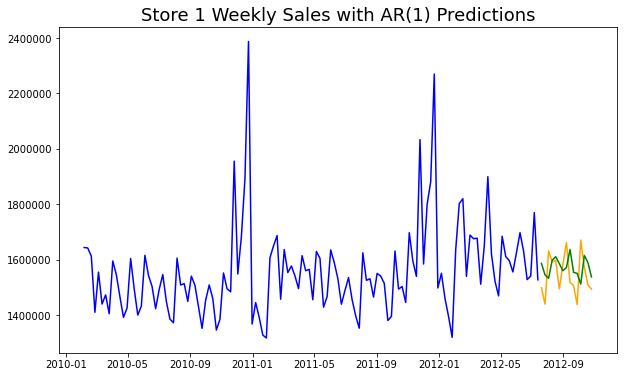

In [83]:
# Plot data
plt.figure(figsize=(10,6))
plt.plot(y_train, color = 'blue')
plt.plot(y_test, color = 'orange')
plt.plot(preds3, color = 'green')
plt.title(label = 'Store 1 Weekly Sales with AR(1) Predictions', fontsize=18)
plt.ticklabel_format(style='plain', axis='y', scilimits=(0,0)); # Remove scientific notation on y-axis
plt.show();

#### Interpretation:

How well or how poorly does the model seem to perform? Provide a brief interpretation.

In [22]:
# A:This model perform worse than ARIMA(2,0,2). 
# This is an indicator that the data is already stationary as the adfuller test suggested.

---

### Fit and evaluate an ARIMA(52,0,1) model

The models above use few autoregressive terms and don't do a good job of capturing the long-term trends that we know exist.

Instantiate and fit an ARIMA of order $(52,0,1)$.

In [72]:
arima4 = ARIMA(endog=store1sum, order = (52,0,1))
model4 = arima4.fit()

### Evaluating the model

**Store predictions**

Generate and store predictions for train and test.

In [73]:
preds4 = model4.predict(start="2012-07-20", end="2012-10-26")
#preds

**Mean squared error**

Find the MSE on your testing data.

In [74]:
mean_squared_error(y_test, preds4) # MSE

2863986615.949614

In [75]:
mean_squared_error(y_test, preds4, squared=False) # RMSE

53516.22759453075

**Generate a plot of the training data, testing data, train preds and test preds**

As before, plot your data and predictions.

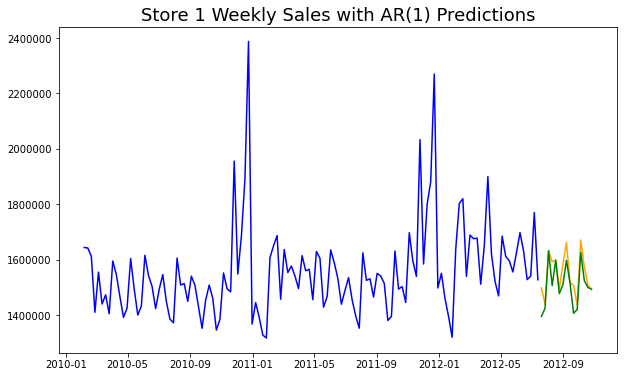

In [84]:
# Plot data
plt.figure(figsize=(10,6))
plt.plot(y_train, color = 'blue')
plt.plot(y_test, color = 'orange')
plt.plot(preds4, color = 'green')
plt.title(label = 'Store 1 Weekly Sales with AR(1) Predictions', fontsize=18)
plt.ticklabel_format(style='plain', axis='y', scilimits=(0,0)); # Remove scientific notation on y-axis
plt.show();

**Interpretation**

How well or how poorly does the model seem to perform? Provide a brief interpretation.

In [23]:
# A: The model perform significantly better as it capture the seasonality of the data.

---

### SARIMA Modeling

Because of the seasonality of this data, a **seasonal** ARIMA model will perform more strongly.

A SARIMA model has an ARIMA portion which behaves as we expect it to. The S part of a SARIMA model allows us to use seasonal terms. The seasonal part of a SARIMA has order $(P, D, Q)_{m}$. $m$ is the **seasonal period** -- the number of observations per season. $P$, $D$, and $Q$ are somewhat similar to the $p$, $d$, and $q$ terms in an ARIMA model, but $P$, $D$, and $Q$ actually backshift by $m$. 

You can read more about SARIMA models here:
- [PennState SARIMA notes](https://online.stat.psu.edu/stat510/lesson/4/4.1)
- [Forecasting: Principles and Practice 3rd ed.](https://otexts.com/fpp3/seasonal-arima.html)

Fit and evaluate a SARIMA model with order $(2,0,2)$ and seasonal order $(1,1,1,52)$. How well does it perform?

> **Note**: SARIMA models are implemented in statsmodels as SARIMAX - the 'X' part allows [exogenous data](https://en.wikipedia.org/wiki/Exogenous_and_endogenous_variables) to be passed in as well, though we won't specify any.
>
> The seasonal order argument is `seasonal_order`.

MSE:1703053104.6095762
RMSE:41268.06397942089


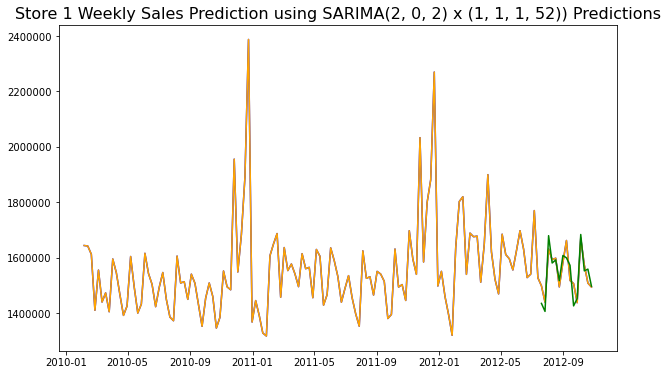

In [85]:
# Fit and visualize a SARIMA(2, 0, 2) x (1, 1, 1, 52) model

sarima = SARIMAX(endog = store1sum,
                 order = (2, 0, 2), # Best (p, d, q)
                 seasonal_order = (1, 1, 1, 52)) # Best (P, D, Q, S)

# Fit SARIMA model
model = sarima.fit()

# Generate predictions based on test set
# Start at time period 150 and end at 187
preds = model.predict(start="2012-07-20", end="2012-10-26")

# Evaluate predictions
print(f"MSE:{mean_squared_error(y_test, preds)}")
print(f"RMSE:{mean_squared_error(y_test, preds, squared=False)}")

# Plot data
plt.figure(figsize=(10,6))
plt.plot(store1sum, color = 'blue')
plt.plot(store1sum, color = 'orange')
plt.plot(preds, color = 'green')
plt.title(label = "Store 1 Weekly Sales Prediction using SARIMA(2, 0, 2) x (1, 1, 1, 52)) Predictions", fontsize=16)
plt.ticklabel_format(style='plain', axis='y', scilimits=(0,0)); # Remove scientific notation on y-axis
plt.show();

The best RMSE from ARIMA(52,0,1) model is ~53516. 
The SARIMA(2, 0, 2) x (1, 1, 1, 52) model perform significantly better with the RMSE of ~41268.
This better capture the seasonal element from the ACF and PACF plot which suggest seasonal element of 52 weeks.